<a href="https://colab.research.google.com/github/probabll/ntmi-tutorials/blob/main/Rational_decision_makers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Decision Theory

**ILOs**

After this tutorial the student 

* understands how to make decisions under uncertainty 
* can implement a search procedure to maximise expected utility (or minimise expected loss) for common probability distributions

In statistical decision theory a **rational decision maker** is one who acts as to maximise expected **utility** (or, equivalently, minimise expected **loss**).

Suppose a decision maker has access to some information $X=x$ and lacks access to some other information captured by a random variable $Y$. The **uncertainty** of the decision maker is captured by a conditional probability distribution $Y|X=x$. The interests of the decision maker are captured by a utility function $u(y, h)$ or, equivalently, by a loss function $\ell(y, h)$. 

The utility function assesses the benefit in choosing $h \in \mathcal Y$ when the true response is $y \in \mathcal Y$. Conversely, the loss function assesses the harm in choosing $h \in \mathcal Y$ when the true response is $y \in \mathcal Y$.

This is the optimisation problem that rational decision makers solve:
\begin{align}
y^\star &= \arg\max_{h \in \mathcal Y} ~ \mathbb E[u(Y, h)|X=x] 
\end{align}
if $Y$ is continuous, then this is
\begin{align}
y^\star &= \arg\max_{h \in \mathcal Y} ~ \int p(y|x) u(y, h) \mathrm{d}y
\end{align}
where $p(y|x)$ is the probability density of $y$ given $x$; if $Y$ is discrete we have 
\begin{align}
y^\star &= \arg\max_{h \in \mathcal Y} ~ \sum_{y \in \mathcal Y} p(y|x) u(y, h) ~.
\end{align}
Or, in English:
* we search in the space of every possible values of $h$, which is every possible value of the random variable $Y$, for the one value whose expected utility is maximum
* expected utility is the average utility against every possible value $y \in \mathcal Y$ of the random variable weighed by their probability density (or mass).

Equivalently, but expressed in terms of a loss function, we have
\begin{align}
y^\star &= \arg\min_{h \in \mathcal Y} ~ \mathbb E[\ell(Y, h)|X=x]  ~.
\end{align}
Or, in English:
* we search in the space of every possible values of $h$, which is every possible value of the random variable $Y$, for the one value whose expected loss is minimum
* expected loss is the average loss against every possible value $y \in \mathcal Y$ of the random variable weighed by their probability density (or mass).

Solving the expected value can be difficult, especially for continuous random variables, since solving $\mathbb E[u(Y, h)|X=x]$ for any given $h$ requires solving an integral. For discrete variables it is generally easier, provided that $\mathcal Y$ is small. In general, we cannot count expected values being easy to solve, but we can *always* estimate them via Monte Carlo (MC) if we have access to a procedure to draw samples from the model (which is available for most reasonable models). The MC estimate of an expected value is:
\begin{align}
\mathbb E[u(Y, h)|X=x]  &\overset{\text{MC}}{\approx} \frac{1}{S}\sum_{s=1}^S u(y_s, h) \quad \text{ with }y_s \sim P_{Y|X=x}
\end{align}
the sample mean utility where we use $S$ samples from the conditional distribution (instead of the entire conditional distribution).

Once we can compute expected utility for a single $h$, or at least estimate it using MC, we have to solve the *search* problem (that is, we need to find out which $h$ in $\mathcal Y$ is the one with highest expected utility / or lowest expected loss). The search problem is in general intractable as well, but, whenever $\mathcal Y$ is low-dimensional, we can at least approximate it using a grid:
\begin{align}
y^\text{grid} &= \arg\max_{h \in \text{grid}} ~ \mathbb E[u(Y, h)|X=x] \\
 &\overset{\text{MC}}{\approx} \arg\max_{h \in \text{grid}} ~ \frac{1}{S}\sum_{s=1}^S u(y_s, h) \quad \text{ with }y_s \sim P_{Y|X=x}
\end{align}

Next we demonstrate this with a few examples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Categorical

For the Categorical distribution we can exactly compute the expected value by enumeration of the terms in $\mathcal Y$, we can also exactly search by having a grid that is exactly identical to $\mathcal Y$. 

Here we will use a utility function that is the "exact match" function, it assigns utility of 1 when the candidate $h$ is equal to the target $y$, and 0 otherwise.

This decision rule happens to return the mode of the Categorical distribution.

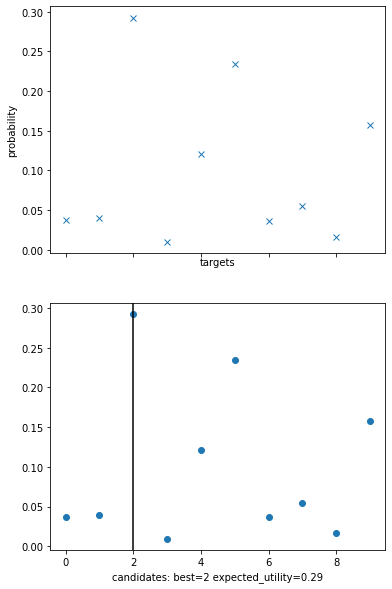

In [2]:
support = np.arange(10)  # mathcal Y
probs = np.random.dirichlet(np.ones(10)) # a valid Categorical parameter
assert np.all(probs > 0), "Should be all positive"
assert np.isclose(np.sum(probs), 1., 1e-3), "Should sum to 1" 
grid = support # with 10 classes we can check each and every candidate

def utility(y, h):
    return np.array((y == h), dtype=float)  # this utility is 1 if the guess is equal to the true or zero otherwise

def exact_expected_utility(h, support, probs):
    return np.sum([utility(y, h) * probs[y] for y in support])

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 10))

_ = axs[0].plot(support, probs, 'x')
_ = axs[0].set_ylabel("probability")
_ = axs[0].set_xlabel("targets")

mu_h = [exact_expected_utility(h, support, probs) for h in grid]
best = np.argmax(mu_h)
_ = axs[1].plot(grid, mu_h, 'o')
_ = axs[1].axvline(grid[best], c='black')
_ = axs[1].set_xlabel(f"candidates: best={grid[best]} expected_utility={mu_h[best]:.2f}")

#Poisson

For the Poisson, we cannot always compute the expected value in closed form because the support of the Poisson is infinite. In reality, for certain choices of utility/loss functions, it is possible to solve the infinite sum exactly, but we will not work with that assumption. Rather, we will use MC estimation.

Here, for illustration, we try two different loss functions, the absolute value $|y-h|$ and the squared difference $(y-h)^2$. These losses are common for numerical ordinal quantities, that's why we use it here. 

Oftentimes these two losses lead to the same optimum (but not always). Even when they do lead to the same optimum decision (a certain value of $h$), note that the expected loss differs tremendously.

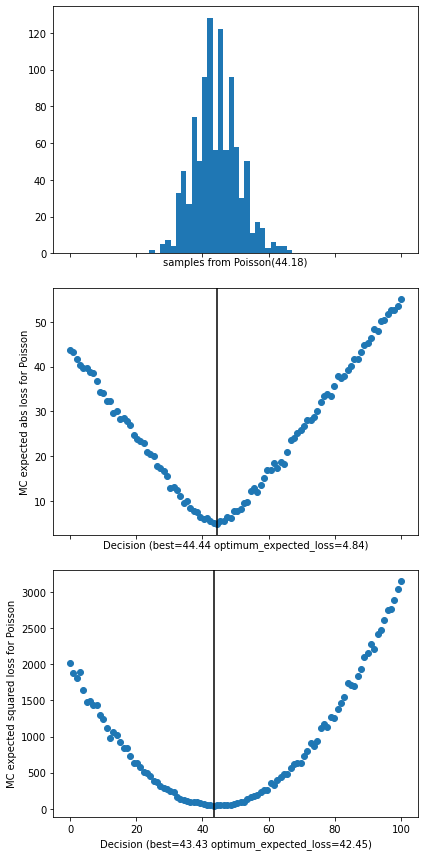

In [3]:
rate = np.random.gamma(20, 2) # a valid Poisson parameter
assert rate > 0, "Should be  positive"

def abs_loss(y, h):
    return np.abs(y-h)  # this loss is the absolute value abs_loss

def squared_loss(y, h):
    return (y-h)**2

def mc_expected_loss_poisson(h, rate, loss, sample_size=100):
    samples = np.random.poisson(rate, size=sample_size)
    return np.mean([loss(y, h) for y in samples])


grid = np.linspace(0, 100, 100)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 12))


# it's good to see what distribution we have
_ = axs[0].hist(np.random.poisson(rate, size=1000), bins='auto')
_ = axs[0].set_xlabel(f"samples from Poisson({rate:.2f})")

# search with abs loss
mu_h = [mc_expected_loss_poisson(h, rate, loss=abs_loss) for h in grid]
best = np.argmin(mu_h)
_ = axs[1].plot(grid, mu_h, 'o')
_ = axs[1].axvline(grid[best], c='black')
_ = axs[1].set_ylabel("MC expected abs loss for Poisson")
_ = axs[1].set_xlabel(f"Decision (best={grid[best]:.2f} optimum_expected_loss={mu_h[best]:.2f})")

# search with squared loss
mu_h = [mc_expected_loss_poisson(h, rate, loss=squared_loss) for h in grid]
best = np.argmin(mu_h)
_ = axs[2].plot(grid, mu_h, 'o')
_ = axs[2].axvline(grid[best], c='black')
_ = axs[2].set_ylabel("MC expected squared loss for Poisson")
_ = axs[2].set_xlabel(f"Decision (best={grid[best]:.2f} optimum_expected_loss={mu_h[best]:.2f})")

fig.tight_layout(h_pad=2, w_pad=2)

# Gamma

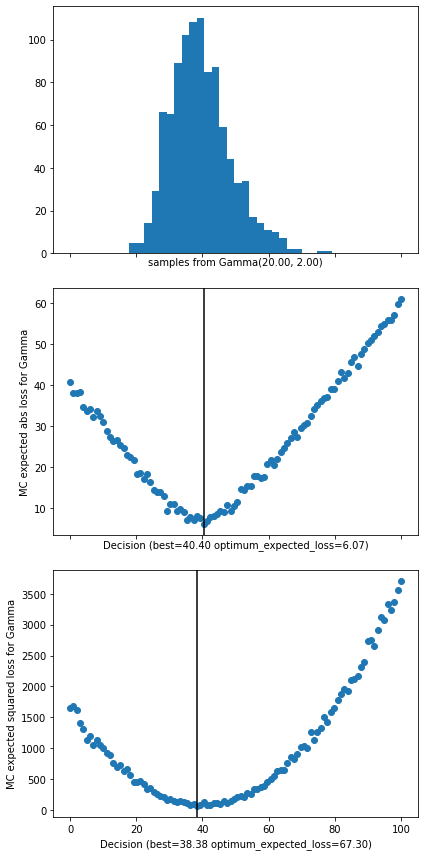

In [4]:
shape = 20.
scale = 2.


def mc_expected_loss_gamma(h, shape, scale, loss, sample_size=100):
    samples = np.random.gamma(shape, scale, size=sample_size)
    return np.mean([loss(y, h) for y in samples])

grid = np.linspace(0, 100, 100)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 12))


# it's good to see what distribution we have
_ = axs[0].hist(np.random.gamma(shape, scale, size=1000), bins='auto')
_ = axs[0].set_xlabel(f"samples from Gamma({shape:.2f}, {scale:.2f})")


# search with abs loss
mu_h = [mc_expected_loss_gamma(h, shape, scale, loss=abs_loss) for h in grid]
best = np.argmin(mu_h)
_ = axs[1].plot(grid, mu_h, 'o')
_ = axs[1].axvline(grid[best], c='black')
_ = axs[1].set_ylabel("MC expected abs loss for Gamma")
_ = axs[1].set_xlabel(f"Decision (best={grid[best]:.2f} optimum_expected_loss={mu_h[best]:.2f})")

# search with squared loss
mu_h = [mc_expected_loss_gamma(h, shape, scale, loss=squared_loss) for h in grid]
best = np.argmin(mu_h)
_ = axs[2].plot(grid, mu_h, 'o')
_ = axs[2].axvline(grid[best], c='black')
_ = axs[2].set_ylabel("MC expected squared loss for Gamma")
_ = axs[2].set_xlabel(f"Decision (best={grid[best]:.2f} optimum_expected_loss={mu_h[best]:.2f})")

fig.tight_layout(h_pad=2, w_pad=2)

# Exercise

Try a different choices of utility functions and/or different choices of distributions.
